In [1]:
# standard 1st 3 lines
%reload_ext autoreload
%autoreload 2
#%matplotlib inline

In [2]:
# standard lib imports
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

In [4]:
PATH = "data/ww2tanks/"
sz=224
bs=24

In [5]:
ls {PATH}

models/  spare/  tmp/  train/  valid/


In [6]:
ls{PATH}valid

pz6/  t34-85/


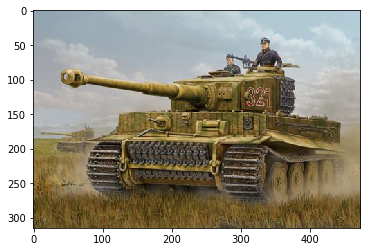

In [7]:
files = !ls {PATH}valid/pz6 | head
img = plt.imread(f'{PATH}valid/pz6/{files[0]}')
plt.imshow(img)

In [8]:
img.shape

(315, 474, 3)

## Step 1
### Enable data augmentation, precompute=True

In [12]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, bs=12,tfms=tfms_from_model(arch,sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

## Step 2
### LR Find

In [13]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 36/50 [00:00<00:00, 311.36it/s, loss=5.15]


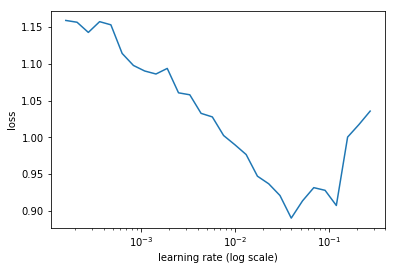

In [14]:
learn.sched.plot()

## Step 3
### Train last layer from precomputed activations for 1-2 epochs

In [15]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.663319   0.175475   0.947917  
    1      0.52475    0.204011   0.90625   



[0.20401084, 0.9062500074505806]

## Step 4
### Train last layer with data augment(precompute=False) for 2-3 epochs with cycle_len=1

In [16]:
tfms = tfms_from_model(resnet34, sz, 
                       aug_tfms=transforms_side_on, max_zoom=1.1)

In [17]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, 
                                          num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [18]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn.set_data(data, precompute=False)
%time learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.333538   0.115722   0.947917  
    1      0.301381   0.138598   0.9375    
    2      0.282768   0.167007   0.9375    

CPU times: user 475 ms, sys: 136 ms, total: 611 ms
Wall time: 440 ms


[0.16700722, 0.9375]

## Step 5
### Unfreeze all layers

In [19]:
learn.unfreeze()

## Step 6
### Set Learning Rate Differentials

In [20]:
lr = np.array([1e-4, 1e-3, 1e-2])

## Step 7
### find learning rate again

In [21]:
learn.lr_find(lr/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.468656   38.946022  0.623197  



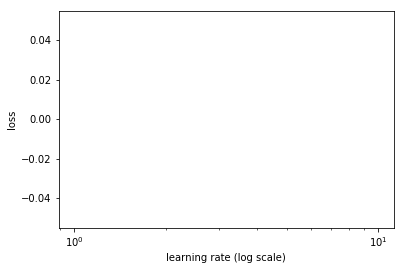

In [22]:
learn.sched.plot()

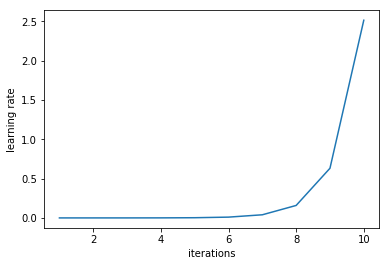

In [23]:
learn.sched.plot_lr()

## Step 8
### Train full network with cycle_mult=2 until overfit

In [24]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.279352   0.12117    0.96875   
    1      0.273627   0.101111   0.960938  
    2      0.259102   0.103213   0.960938  
    3      0.252222   0.10728    0.960938  
    4      0.24344    0.096669   0.960938  
    5      0.228728   0.091589   0.960938  
    6      0.231091   0.089512   0.960938  



[0.08951155, 0.9609375]

In [26]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), axis=0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9888888888888889, 0.12355710816084159)